In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.path as mpath
import plotly.express as px
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator, CubicSpline, interp1d, PchipInterpolator
from scipy.spatial import Delaunay
import os
import json
from tqdm import tqdm

In [18]:
def loadData(filePath):
    with open(filePath, 'r') as f:
        data = json.load(f)
    
    keys_single = ['nodes', 'elements', 'solution', 'elementsBoundaryNodesOnly','areaElementsBoundaryNodesOnly']
    for i in tqdm(range(len(data))):
        for key in data[i].keys():
            if key in keys_single:
                data[i][key] = np.array(data[i][key])
            else:
                for j in range(len(data[i][key])):
                    if type(data[i][key][j]) == list:
                        data[i][key][j] = np.array(data[i][key][j])
    return data

data_arr = loadData('TrainingData/LowReFlowDataProcessed/dataLowReFLow.json')

100%|██████████| 3973/3973 [00:07<00:00, 542.12it/s]


In [19]:
def GetAreaTriang(nodes_els):
    # Calculate the area of a triangles in a mesh
    #   nodes_els - [N,3,2] tensor which containes the x,y positions of nodes of N triangles
    b = (np.roll(nodes_els[:,:,1],1,axis=1) - np.roll(nodes_els[:,:,1],2,axis=1)).reshape(-1,3,1)
    c = (np.roll(nodes_els[:,:,0],2,axis=1) - np.roll(nodes_els[:,:,0],1,axis=1)).reshape(-1,3,1)
    Area = np.abs(np.matmul(nodes_els[:,:,0].reshape(-1,1,3),b))/2
    return Area

def RandomTriangSample(nodes):
    # Sample a random points inside a trinagle defined by [3,2] matrix: nodes
    y = np.random.uniform()
    x = np.abs(np.random.uniform()-np.random.uniform())
    p = nodes[1] + (nodes[0]-nodes[1])*x - (nodes[1]-nodes[2])*(1-x)*y
    return p

def RandomMeshSample(nodes,elements,Area=None):
    # Sample a random point from a 2D shape defined with a mesh: (nodes, elements)
    if Area is None:
        Area = GetAreaTriang(nodes[elements]).flatten()
    el_sample = np.random.choice(np.arange(elements.shape[0]),p=Area/Area.sum())
    point_sample = RandomTriangSample(nodes[elements[el_sample]])
    return point_sample

In [29]:
for data in tqdm(data_arr):
    nodesBMesh = np.concatenate(data['nodesCurves'])
    idxNodesBMesh = np.concatenate(data['idxCurves'])
    tri = Delaunay(nodesBMesh)
    triangles = tri.simplices

    idx_pick = np.logical_not((triangles>len(data['nodesCurves'][0])-1).all(1))
    triangles = triangles[idx_pick]

    triangles = idxNodesBMesh[triangles]
    data['elementsBoundaryNodesOnly'] = triangles

    area = GetAreaTriang(data['nodes'][triangles]).flatten()
    data['areaElementsBoundaryNodesOnly'] = area

100%|██████████| 3973/3973 [00:04<00:00, 975.65it/s] 


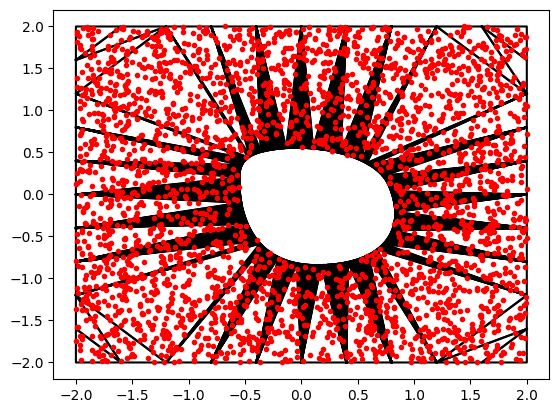

In [21]:
i = 2000
data = data_arr[i]


nodes = data['nodes']
triangles = data['elementsBoundaryNodesOnly']
area = data['areaElementsBoundaryNodesOnly']
n_samples = 3000
samples = np.zeros((n_samples,2))
for i in range(n_samples):
    samples[i] = RandomMeshSample(nodes,triangles,area)

for triangle in triangles:
    plt.plot(nodes[triangle[[0,1,2,0]],0], nodes[triangle[[0,1,2,0]],1], 'k-')

plt.plot(samples[:,0],samples[:,1],'r.')

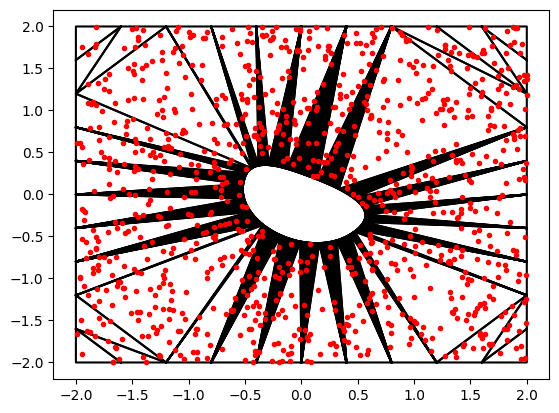

In [27]:
data = data_arr[0]

nodesMesh = np.concatenate(data['nodesCurves'])
idxNodesMesh = np.concatenate(data['idxCurves'])
n_edges = np.cumsum([len(curve) for curve in (data['nodesCurves'])])
tri = Delaunay(nodesMesh)
triangles = tri.simplices

idx_pick = np.logical_not((triangles>len(data['nodesCurves'][0])-1).all(1))
triangles = triangles[idx_pick]

triangles = idxNodesMesh[triangles]

nodes = data['nodes']
for triangle in triangles:
    plt.plot(nodes[triangle[[0,1,2,0]],0], nodes[triangle[[0,1,2,0]],1], 'k-')

area = GetAreaTriang(nodes[triangles])
n_samples = 1000
samples = np.zeros((n_samples,2))
for i in range(n_samples):
    samples[i] = RandomMeshSample(nodes,triangles,area)

plt.plot(samples[:,0],samples[:,1],'r.')



# plt.figure(figsize=(10,10))
# plt.triplot(nodesMesh[:,0], nodesMesh[:,1], triangles)
# plt.xlim([-1,0])
# plt.ylim([0,0.5])

In [24]:
area.shape

(353, 1, 1)

In [3]:
keys = ['nodes', 'elements', 'edges', 'flow']
data_files = {}

for key in keys:
    files = os.listdir('TrainingData/LowReFlowData/dataset_shapes_gcnn/' + key + '/')
    files = [f for f in files if f.endswith('.csv')]
    code = [int(f.split('_')[1].split('.')[0]) for f in files]
    data_files[key+'_files'] = files
    data_files[key+'_code'] = code
    

In [4]:
dataO = []

for i in tqdm(range(len(data_files['nodes_files']))):
    nodes = pd.read_csv('TrainingData/LowReFlowData/dataset_shapes_gcnn/nodes/' + data_files['nodes_files'][i])
    elements = pd.read_csv('TrainingData/LowReFlowData/dataset_shapes_gcnn/elements/' + data_files['elements_files'][i])
    edges = pd.read_csv('TrainingData/LowReFlowData/dataset_shapes_gcnn/edges/' + data_files['edges_files'][i])
    flow = pd.read_csv('TrainingData/LowReFlowData/dataset_shapes_gcnn/flow/' + data_files['flow_files'][i])
    dataO.append({'nodes':nodes, 'elements':elements, 'edges':edges, 'flow':flow})

  0%|          | 0/3973 [00:00<?, ?it/s]

100%|██████████| 3973/3973 [00:15<00:00, 262.30it/s]


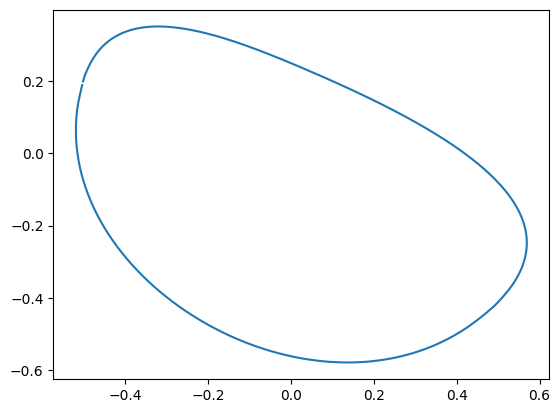

In [16]:
nodes = dataO[0]['nodes']
flow = dataO[0]['flow']
nodesB = nodes[nodes['Object']==0.0]
flowB = flow.iloc[nodesB.index]
plt.plot(nodesB['x'],nodesB['y'])

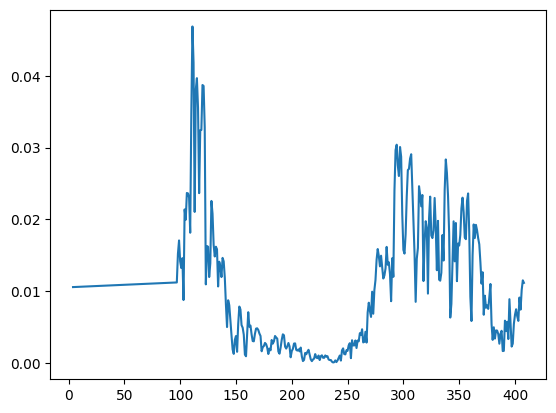

In [19]:
plt.plot(flowB['u'])

In [15]:
dataO[0].keys()

dict_keys(['nodes', 'elements', 'edges', 'flow'])

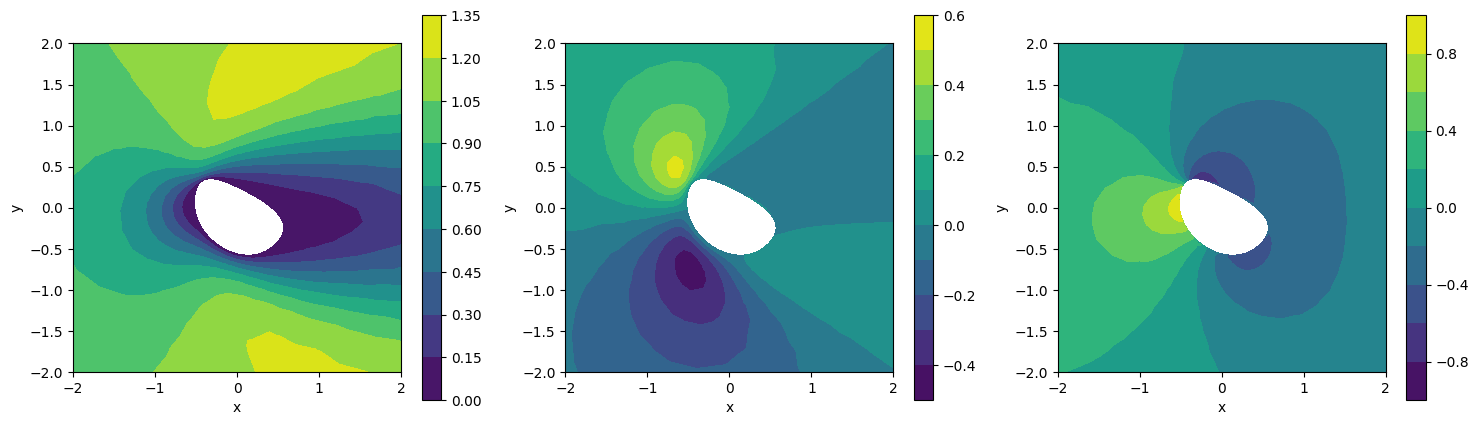

In [9]:
def PlotFEMsolution(nodes, elements,l):
    if elements.shape[1] == 4:
        # Convert quadrlateral mesh to triangular mesh
        elements = np.concatenate([elements[:,:3],elements[:,1:]],0)

    # Create a Triangulation object
    triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], elements)

    # Plotting
    r = l.shape[1]
    plt.figure(figsize=(6*r,5))
    for i in range(r):
        plt.subplot(1,r,i+1)
        plt.tricontourf(triangulation, l[:,i],10)
        plt.colorbar()
        # plt.scatter(nodes[:,0],nodes[:,1],s=1,c='k')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.gca().set_aspect('equal', adjustable='box')
    return 

PlotFEMsolution(dataO[0]['nodes'].values, dataO[0]['elements'].values, dataO[0]['flow'].values)

In [506]:
def computeLengthAlongCurve(nodesB):
    dl = np.sqrt(((nodesB[1:]-nodesB[:-1])**2).sum(1))
    l = np.cumsum(dl)
    l = np.concatenate([[0],l],0)
    return l

def GetNormals(nodesB, distanceCurves):
    nodesB_expand = np.concatenate([nodesB[-2:-1],nodesB,nodesB[1:2]],0)
    alpha_expand = np.concatenate([[distanceCurves[-2]-distanceCurves[-1]],distanceCurves,[distanceCurves[-1]+distanceCurves[1]]],0).reshape(-1,1)
    dalpha = alpha_expand[2:]-alpha_expand[1:-1]
    dalpha1 = alpha_expand[1:-1]-alpha_expand[0:-2]
    c = dalpha1/dalpha
    dNodesdAlpha = c/((c+1)*dalpha) * nodesB_expand[2:] + (1-c)/(c*dalpha) * nodesB_expand[1:-1] - 1/(c*(c+1)*dalpha) * nodesB_expand[0:-2]
    normal = np.stack([dNodesdAlpha[:,1],-dNodesdAlpha[:,0]],axis=1)
    normal = normal/np.sqrt((normal**2).sum(1)).reshape(-1,1)
    normal[-1] = normal[0]
    return normal

def getSolutionDataStructure(nodes, elements, flow):
    data = {}

    # Domain data
    data['nodes'] = nodes[['x','y']].values
    data['elements'] = elements[['V1','V2','V3']].values
    data['solution'] = flow[['u','v','p']].values

    # Boundary curves data
    idxCurve2 = nodes[nodes['Object']==0].index
    idxCurve2 = np.concatenate([idxCurve2,idxCurve2[0:1]],0)
    idxCurve1 = np.concatenate([
        nodes[nodes['y']==-2].sort_values(by='x',ascending=True)[['x','y']].index,
        nodes[nodes['x']==2].sort_values(by='y',ascending=True)[['x','y']].index[1:],
        nodes[nodes['y']==2].sort_values(by='x',ascending=False)[['x','y']].index[1:],
        nodes[nodes['x']==-2].sort_values(by='y',ascending=False)[['x','y']].index[1:],
    ])
    data['idxCurves'] = [idxCurve1,idxCurve2]
    data['distanceCurves'] = []
    data['nodesCurves'] = []
    data['lengthCurves'] = []
    data['normalCurves'] = []
    for i in range(len(data['idxCurves'])):
        nodesB = data['nodes'][data['idxCurves'][i]]
        data['distanceCurves'].append(computeLengthAlongCurve(nodesB))
        data['nodesCurves'].append(nodesB)
        data['lengthCurves'].append(data['distanceCurves'][i][-1])
        data['normalCurves'].append(GetNormals(nodesB,data['distanceCurves'][i]))

    # Boundary corners data
    data['idxCorner'] = nodes[nodes['x'].isin([-2,2]) & nodes['y'].isin([-2,2])].index.values.tolist()
    data['idxCurveCorner'] = [0,0,0,0]
    data['idxCornerCurve'] = [np.where(data['idxCurves'][data['idxCurveCorner'][i]] == data['idxCorner'][i])[0][0] for i in range(len(data['idxCorner']))]
    data['distaceCornerCurve'] = [data['distanceCurves'][data['idxCurveCorner'][i]][data['idxCornerCurve'][i]] for i in range(len(data['idxCorner']))]
    return data

nodes = dataO[0]['nodes']
elements = dataO[0]['elements']
flow = dataO[0]['flow']

# data = {}

# # Domain data
# data['nodes'] = nodes[['x','y']].values
# data['elements'] = elements[['V1','V2','V3']].values
# data['solution'] = flow[['u','v','p']].values

# # Boundary curve data
# idxCurve2 = nodes[nodes['Object']==0].index
# idxCurve2 = np.concatenate([idxCurve2,idxCurve2[0:1]],0)
# idxCurve1 = np.concatenate([
#     nodes[nodes['y']==-2].sort_values(by='x',ascending=True)[['x','y']].index,
#     nodes[nodes['x']==2].sort_values(by='y',ascending=True)[['x','y']].index[1:],
#     nodes[nodes['y']==2].sort_values(by='x',ascending=False)[['x','y']].index[1:],
#     nodes[nodes['x']==-2].sort_values(by='y',ascending=False)[['x','y']].index[1:],
# ])
# data['idxCurves'] = [idxCurve1,idxCurve2]
# data['distanceCurves'] = []
# data['nodesCurves'] = []
# data['lengthCurves'] = []
# data['normalCurves'] = []
# for i in range(len(data['idxCurves'])):
#     nodesB = data['nodes'][data['idxCurves'][i]]
#     data['distanceCurves'].append(computeLengthAlongCurve(nodesB))
#     data['nodesCurves'].append(nodesB)
#     data['lengthCurves'].append(data['distanceCurves'][i][-1])
#     data['normalCurves'].append(GetNormals(nodesB,data['distanceCurves'][i]))

# data['idxCorner'] = nodes[nodes['x'].isin([-2,2]) & nodes['y'].isin([-2,2])].index.values.tolist()
# data['idxCurveCorner'] = [0,0,0,0]
# data['idxCornerCurve'] = [np.where(data['idxCurves'][data['idxCurveCorner'][i]] == data['idxCorner'][i])[0][0] for i in range(len(data['idxCorner']))]
# data['distaceCornerCurve'] = [data['distanceCurves'][data['idxCurveCorner'][i]][data['idxCornerCurve'][i]] for i in range(len(data['idxCorner']))]


# data = getSolutionDataStructure(nodes, elements, flow)

data_arr = []

for i in tqdm(range(len(data_files['nodes_files']))):
    nodes = pd.read_csv('TrainingData/LowReFlowData/dataset_shapes_gcnn/nodes/' + data_files['nodes_files'][i])
    elements = pd.read_csv('TrainingData/LowReFlowData/dataset_shapes_gcnn/elements/' + data_files['elements_files'][i])
    # edges = pd.read_csv('TrainingData/LowReFlowData/dataset_shapes_gcnn/edges/' + data_files['edges_files'][i])
    flow = pd.read_csv('TrainingData/LowReFlowData/dataset_shapes_gcnn/flow/' + data_files['flow_files'][i])
    data_arr.append(getSolutionDataStructure(nodes, elements, flow))

100%|██████████| 3973/3973 [00:19<00:00, 207.59it/s]


In [42]:
data_arr_list = data_arr.copy()

for i in tqdm(range(len(data_arr_list))):
    data = data_arr_list[i]
    for key in data.keys():
        if type(data[key]) == np.ndarray:
            data[key] = data[key].tolist()
        elif type(data[key]) == list:
            if type(data[key][0]) == np.ndarray:
                for j in range(len(data[key])):
                    data[key][j] = data[key][j].tolist()
            elif type(data[key][0]) == np.int64:
                data[key] = [int(x) for x in data[key]]

100%|██████████| 3973/3973 [00:12<00:00, 327.24it/s]


In [43]:
# write to a json file
with open('TrainingData/LowReFlowDataProcessed/dataLowReFLow.json', 'w') as f:
    json.dump(data_arr_list, f)

In [8]:
class IsInDomain:
    def __init__(self, nodesCurves):
        self.loops = [mpath.Path(nodesCurves[i]) for i in range(len(nodesCurves))]
        
    def __call__(self, points):
        return np.logical_and(self.loops[0].contains_points(points),np.logical_not(np.array([loop.contains_points(points) for loop in self.loops[1:]]).any(0)))

class Interp2DInDomain:
    def __init__(self,points,vals,isInDomainF):
        self.interpF = CloughTocher2DInterpolator(points,vals)
        self.inInDomainF = isInDomainF
    
    def __call__(self,points):
        vals = self.interpF(points)
        vals[~self.inInDomainF(points)] = np.nan
        return vals
    
class Interp1DPeriodic:
    def __init__(self, x, y, kind = 'linear'):
        self.x = x
        self.y = y
        self.kind = kind
        self.spline = interp1d(self.x,self.y,kind=self.kind,axis=0)
    
    def __call__(self, x):
        return self.spline(x%self.x[-1])
    
class Interp1DPchipPeriodic:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.spline = PchipInterpolator(self.x,self.y,axis=0)
    
    def __call__(self, x):
        return self.spline(x%self.x[-1])
    
def addInterpF2Data(data):
    valSliceE = slice(0,3)
    valSliceD = slice(0,2)

    data['isInDomainF'] = IsInDomain(data['nodesCurves'])
    data['interpSE'] = Interp2DInDomain(data['nodes'],data['solution'][:,valSliceE],data['isInDomainF'])
    data['interpSD'] = Interp2DInDomain(data['nodes'],data['solution'][:,valSliceD],data['isInDomainF'])

    data['solutionB'] = []
    data['interpBS'] = []
    data['interpBN'] = []
    data['interpBC'] = []
    for i in range(len(data['idxCurves'])):
        data['solutionB'].append(data['solution'][data['idxCurves'][i]])
        data['interpBS'].append(Interp1DPchipPeriodic(data['distanceCurves'][i],data['solutionB'][i]))
        data['interpBN'].append(Interp1DPchipPeriodic(data['distanceCurves'][i],data['normalCurves'][i]))
        data['interpBC'].append(Interp1DPchipPeriodic(data['distanceCurves'][i],data['nodesCurves'][i]))
    # return data

# addInterpF2Data(data)

In [10]:
def loadData(filePath):
    with open(filePath, 'r') as f:
        data = json.load(f)
    
    keys_single = ['nodes', 'elements', 'solution']
    for i in tqdm(range(len(data))):
        for key in data[i].keys():
            if key in keys_single:
                data[i][key] = np.array(data[i][key])
            else:
                for j in range(len(data[i][key])):
                    if type(data[i][key][j]) == list:
                        data[i][key][j] = np.array(data[i][key][j])
        addInterpF2Data(data[i])
    return data

data_arr = loadData('TrainingData/LowReFlowDataProcessed/dataLowReFLow.json')

100%|██████████| 3973/3973 [01:16<00:00, 51.66it/s]


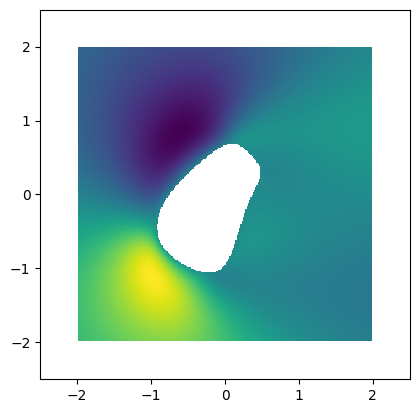

In [17]:
data = data_arr[1000]

n = 300
x = np.linspace(-2.5,2.5,n)
X,Y = np.meshgrid(x,x)
points = np.stack([X.flatten(),Y.flatten()],axis=1)
sol = data['interpSE'](points).reshape(n,n,3)
plt.imshow(sol[:,:,1],extent=[-2.5,2.5,-2.5,2.5])

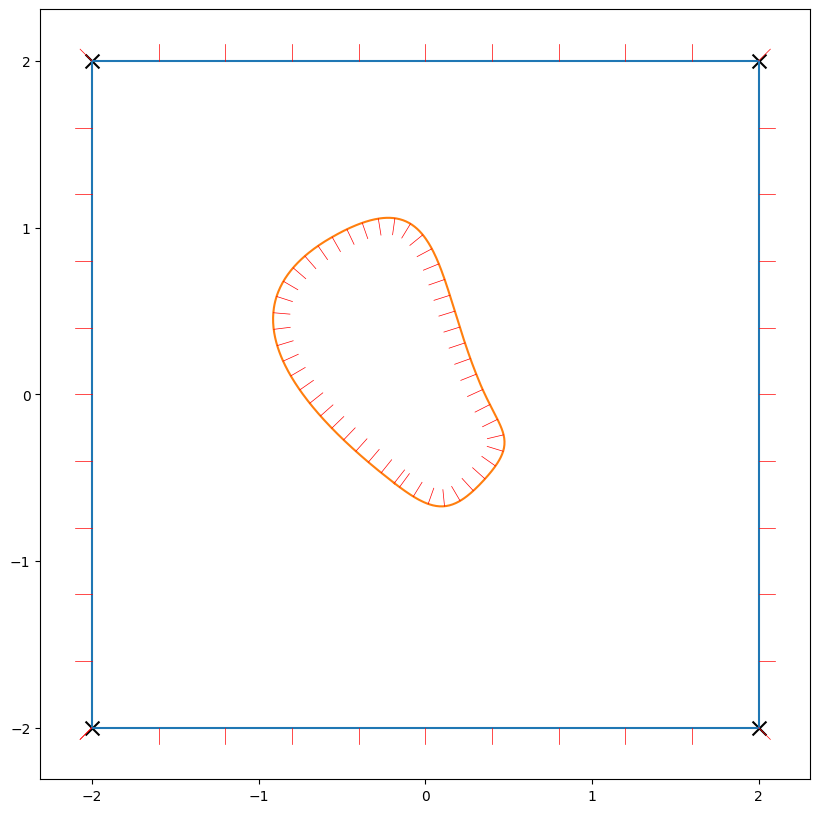

In [18]:
nodes = data['nodes']
idxCurve1 = data['idxCurves'][0]
idxCurve2 = data['idxCurves'][1]
nodesB1 = nodes[idxCurve1]
normals1 = data['normalCurves'][0]
nodesB2 = nodes[idxCurve2]
normals2 = data['normalCurves'][1]
plt.figure(figsize=(10,10))
plt.plot(nodesB1[:,0],nodesB1[:,1])
k = 0.1
for i in range(nodesB1.shape[0]):
    plt.plot([nodesB1[i,0],nodesB1[i,0]+k*normals1[i,0]],[nodesB1[i,1],nodesB1[i,1]+k*normals1[i,1]],'r',linewidth=0.5)
plt.plot(nodesB2[:,0],nodesB2[:,1])
for i in range(0,nodesB2.shape[0],10):
    plt.plot([nodesB2[i,0],nodesB2[i,0]+k*normals2[i,0]],[nodesB2[i,1],nodesB2[i,1]+k*normals2[i,1]],'r',linewidth=0.5)
plt.gca().set_aspect('equal', adjustable='box')

plt.scatter(nodes[data['idxCorner'],0],nodes[data['idxCorner'],1],s=100,marker='x',c='k')